In [1]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset, WineDataset
# from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models.original_models as original_models
import models.models_3d_atomics_on_variate_to_concepts as new_models
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print(device, torch.cuda.current_device())
# device = "cpu"

cuda 0


176

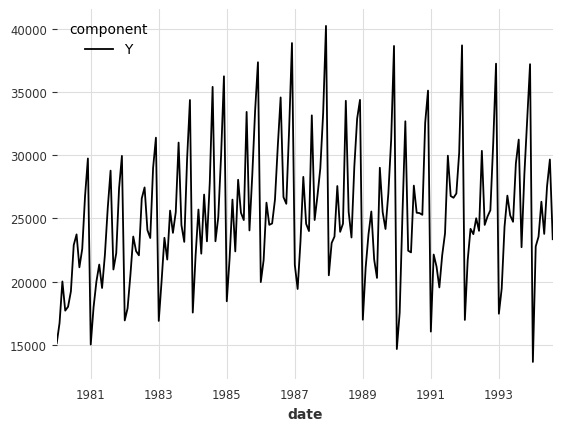

In [2]:
wine_series = WineDataset().load().pd_dataframe()
wine_series.plot()
len(wine_series)

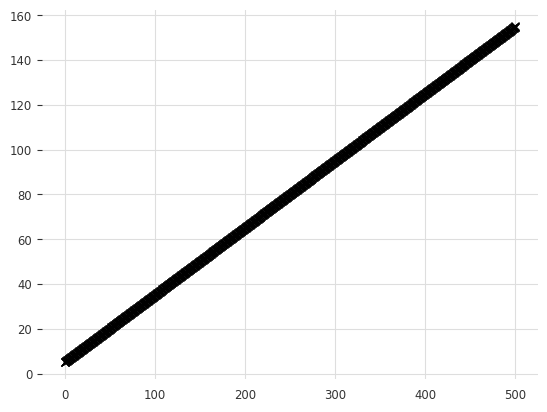

In [20]:

def line(x, w=0.3, b=5):
    return w*x + b

time = np.linspace(0, 500, 1000).reshape(-1,1)

trend_series = line(time)
trend_series = np.array(trend_series).reshape(-1,1)

plt.plot(time, trend_series, marker="x")
plt.show()

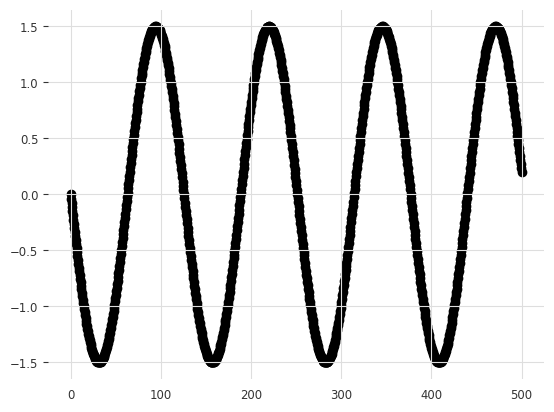

In [22]:

def sine_wave(time, frequency = 1, amplitude = 1, phase = 0):
    return amplitude * np.sin(frequency * time + phase)

sine_series = sine_wave(time, frequency = 0.05, amplitude = 1.5, phase = np.pi)

plt.scatter(time, sine_series)
plt.show()

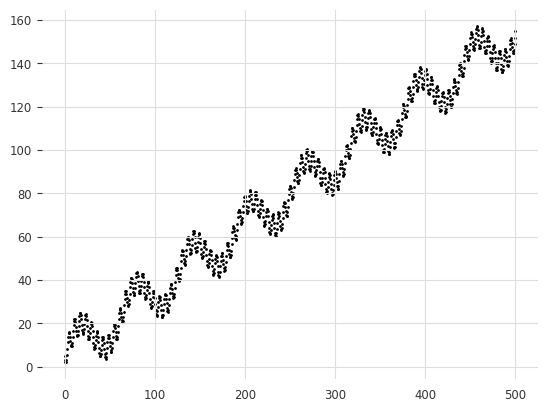

In [23]:

components_series = sine_wave(time, frequency = 1, amplitude = 5, phase = np.pi) \
                + sine_wave(time, frequency = 0.1, amplitude = 10, phase = 0) \
                + trend_series

plt.scatter(time[:3000], components_series[:3000], s=1)
plt.show()

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [25]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 512):
    scaler = StandardScaler()
    
    train_end = int(len(series) * 0.6)
    val_end = int(train_end + len(series) * 0.2)
    
    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]
    
    # train, test = series.split_before(0.6)
    # val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train = scaler.fit_transform(train)
    X_train = pd.DataFrame(train)
    y_train = X_train
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=0, pin_memory=True)

    val = scaler.transform(val)
    X_val = pd.DataFrame(val)
    y_val = X_val
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=0, pin_memory=True)

    test = scaler.transform(test)
    X_test = pd.DataFrame(test)
    y_test = X_test
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


Train/Val/Test 600 200 200
torch.Size([491, 100, 2]) False
torch.Size([491, 10]) False


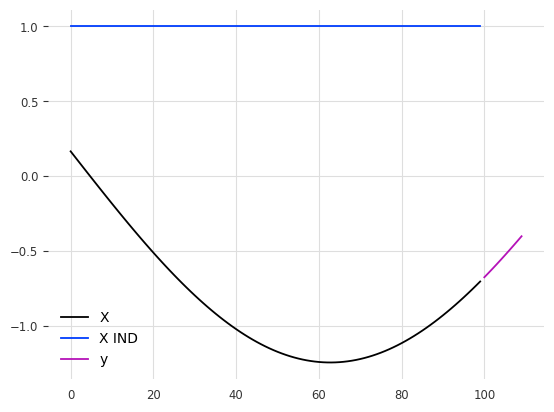

Batches 1 1 1


In [26]:
seq_len = 100
pred_len = 10

train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

for X,y in train_loader:
    print(X.shape, X.requires_grad)
    print(y.shape, X.requires_grad)
    break

i = 0
plt.plot(range(seq_len), X[i, :, 0], label="X")
plt.plot(range(seq_len), X[i, :, 1], label="X IND")
plt.plot(range(seq_len, seq_len + pred_len), y[i], label="y")
plt.legend()
plt.show()


print("Batches", len(train_loader), len(val_loader), len(test_loader))


In [27]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title, dec="{:.3g}"):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    xtick_labels = list(map(int, history[:, 0]))
    plt.xticks(xticks, xtick_labels)
    plt.yscale('log')

    if dec:
        for x,_y in zip(xticks, history[:, 2]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            
        for x,_y in zip(xticks, history[:, 3]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "mae", "mse"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["mae"], label='MAE')
    plt.plot(mean_atomics.index, mean_atomics["mse"], label='MSE')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["mae"], label='MAE')
    plt.plot(mean_concepts.index, mean_concepts["mse"], label='MSE')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()
    

def plot_prediction_vs_true(Xb, yb, preds, title):
    x = list(range(len(Xb)))
    xx = list(range(len(Xb), len(Xb)+len(yb)))
    plt.plot(x, Xb, color="black", label="True X")
    plt.plot(xx, yb, color="blue", label="True y")
    plt.plot(xx, preds, color="red", label="Pred y")
    plt.title(title)
    plt.yscale("linear")
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.legend()
    plt.show()


In [53]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = original_models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=original_models.TaskType.REGRESSION,
                            device=device
                            )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim, use_summaries_for_atomics, use_indicators, top_k=''):
    model = new_models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics = n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            opt_lr = 1e-3, # 2e-4
                            opt_weight_decay = 1e-5, # 1e-05,
                            l1_lambda=1e-5, # 0.001,
                            cos_sim_lambda=1e-5, # 0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=new_models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [54]:
random_seed = 1
set_seed(random_seed)


In [60]:
seq_len = 20
pred_len = 10
n_atomics_list = list(range(2,11,2))
n_concepts_list = list(range(2,11,2))
changing_dim = 1 #len(series.columns)
input_dim = 2 * changing_dim

n_atomics = 1024
n_concepts = 1024

## Blaaa

In [48]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/debug/debugging-L{seq_len}-T{pred_len}/"
# model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"
model_path_re = experiment_folder + "forecasting_c{}.pt"

# if not os.path.exists(experiment_folder):
#     os.makedirs(experiment_folder)

In [61]:
mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

maes, mses = [], []

for _ in range(1):
    
    train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)
    model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True, use_indicators=False)
    # model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

    scheduler = None # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=10, factor=0.7, verbose=True)

    # model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
    model.fit(train_loader, val_loader, None, save_model_path=None, max_epochs=10000, scheduler=scheduler, patience=100)

    # display(model)

    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(train_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()

        # print("MSE", round(mse, 5), "MAE", round(mae, 5))

    maes.append(mae)
    mses.append(mse)

mae = np.mean(maes)
mse = np.mean(mses)
print("MEAN", "MSE", round(mse, 5), "MAE", round(mae, 5))


# with torch.no_grad():
#     for batch_idx, (Xb, yb) in enumerate(train_loader):
#         Xb, yb = Xb.to(device), yb.to(device)
#         preds = model(Xb)
#         break


#     i = 2
#     yb = yb.cpu().numpy()[i].reshape(-1, 1)
#     preds = preds.cpu().numpy()[i].reshape(-1, 1)
#     Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

# plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
# display(pd.DataFrame(yb.flatten(), preds.flatten()))


# plot_losses(model.train_losses[5:], model.val_losses[5:])

# model.eval()
# with torch.no_grad():
#     for batch_idx, (Xb, yb) in enumerate(test_loader):
#         Xb, yb = Xb.to(device), yb.to(device)
#         preds = model(Xb)
        
#         mae = mae_metric(preds, yb).item()
#         mse = mse_metric(preds, yb).item()
#     mae = mae_metric.compute().item()
#     mse = mse_metric.compute().item()
#     mae_metric.reset()
#     mse_metric.reset()

#     print("MSE", round(mse, 5), "MAE", round(mae, 5))


#     for batch_idx, (Xb, yb) in enumerate(test_loader):
#         Xb, yb = Xb.to(device), yb.to(device)
#         preds = model(Xb)
#         break



# i = 0
# yb = yb.cpu().numpy()[i].reshape(-1, 1)
# preds = preds.cpu().numpy()[i].reshape(-1, 1)
# Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

# plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
# display(pd.DataFrame(yb.flatten(), preds.flatten()))



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train/Val/Test 600 200 200


  0%|          | 0/10000 [00:00<?, ? epoch/s]

  0%|          | 0/10000 [00:00<?, ? epoch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 15.99 GiB (GPU 0; 79.35 GiB total capacity; 64.38 GiB already allocated; 8.52 GiB free; 66.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# multi
# relu 20x20
MEAN MSE 0.00062 MAE 0.01805

# relu 256x256
MEAN MSE 0.00161 MAE 0.03197

# sigmoid 20x20
MEAN MSE 0.00025 MAE 0.01170

# sigmoid 256x256
MEAN MSE 0.00237 MAE 0.03899




# 1ahead
# relu 20x20
MEAN MSE 0.00174 MAE 0.03148

# relu 256x256
MEAN MSE 0.00322 MAE 0.04281

# sigmoid 20x20
MEAN MSE 0.00236 MAE 0.03673

# sigmoid 256x256
MEAN MSE 0.01041 MAE 0.07715


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)


model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=10, factor=0.7, verbose=True)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("sine_cutoff"), max_epochs=100000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


plot_losses(model.train_losses[5:], model.val_losses[5:])


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)


model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=10, factor=0.7, verbose=True)

# model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts, n_atomics), max_epochs=10000, scheduler=scheduler)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("components_series_cutoff"), max_epochs=100000, scheduler=scheduler, patience=100)


model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


plot_losses(model.train_losses[5:], model.val_losses[5:])


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i, :, 0].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"Redesigned - Predictions with {n_concepts} Concepts, {n_atomics} Atomics")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

print(model)
# print(model.named_parameters)

# for name, param in model.named_parameters():
#     print(name, param.shape, param.requires_grad, param.device, param.dtype)
#     if param.grad is not None:
#         print(f"Parameter: {name}, Gradient: {param}")


model.fit(train_loader, val_loader, None, save_model_path=None, max_epochs=100, patience=100, show_grad=True)
